## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os                                                                       
import numpy as np                                                              
import tensorflow as tf                                                         
import models.model_picker as mp
import params.param_picker as pp
import data.data_picker as dp                                                   
import utils.log_parser as lp
import utils.plot_functions as pf                                               
import utils.image_processing as ip                                             
import analysis.analysis_picker as ap
import utils.notebook as nb

In [3]:
analysis_params = {
  "model_type": "lca",
  "model_name": "analysis_test",
  "data_type": "vanhateren",
  "device": "/gpu:0",
  "version": "0.0",
  "clobber": True}

# Computed params
analysis_params["model_dir"] = (os.path.expanduser("~")+"/Work/Projects/"
  +analysis_params["model_name"])
analysis_params["out_dir"] = (analysis_params["model_dir"]+"/analysis/"
  +analysis_params["version"]+"/")

In [4]:
analyzer = ap.get_analyzer(analysis_params)

In [5]:
data = dp.get_data(analysis_params["data_type"], analyzer.model_params)
analyzer.model_params["input_shape"] = [
  data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]

In [6]:
if not analysis_params["clobber"] and os.path.exists(analysis_params["out_dir"]+"analyzer_obj.npz"):
  analyzer.load_analysis(analysis_params["out_dir"]+"analyzer_obj.npz")
else:
  analyzer.run_analysis(data["train"].images)

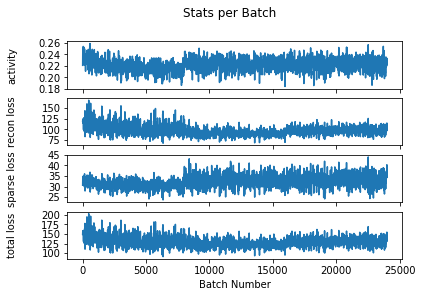

In [7]:
stats_fig = pf.plot_stats(analyzer.run_stats,
  keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"],
  labels=["activity", "recon loss", "sparse loss", "total loss"])

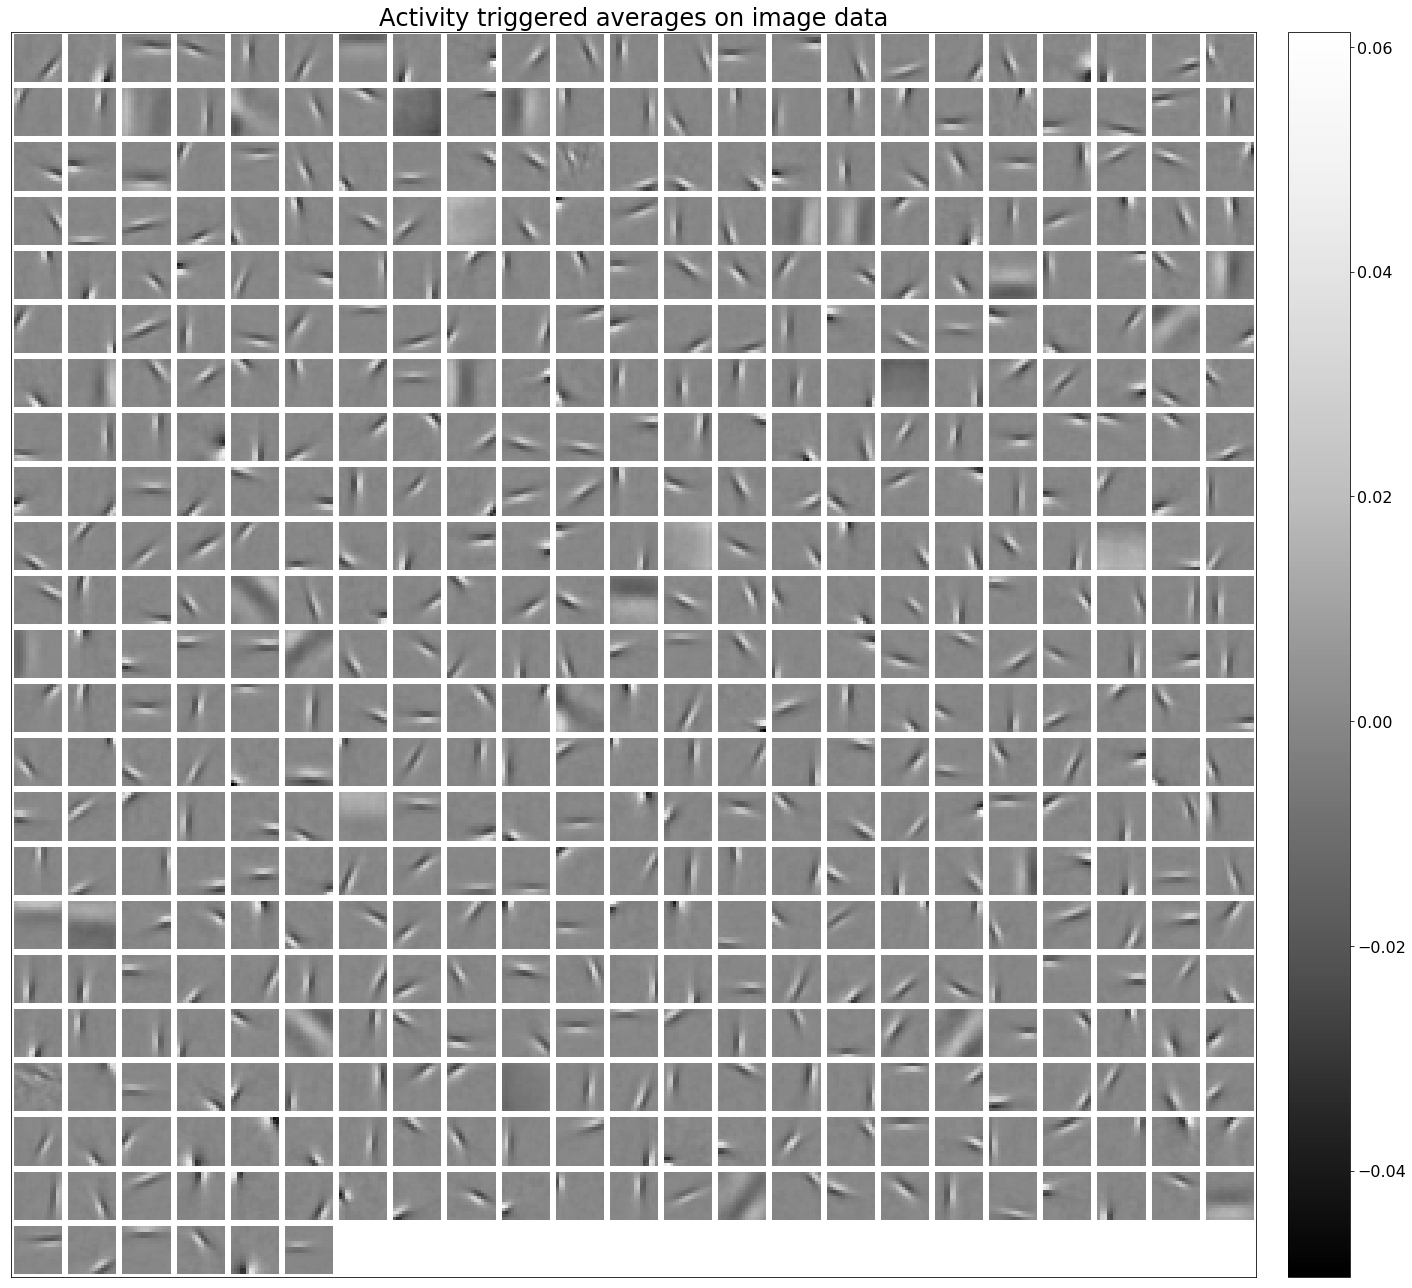

In [8]:
num_pixels, num_neurons = analyzer.atas.shape
atas_fig = pf.plot_data_tiled(analyzer.atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), normalize=False,
  title="Activity triggered averages on image data")

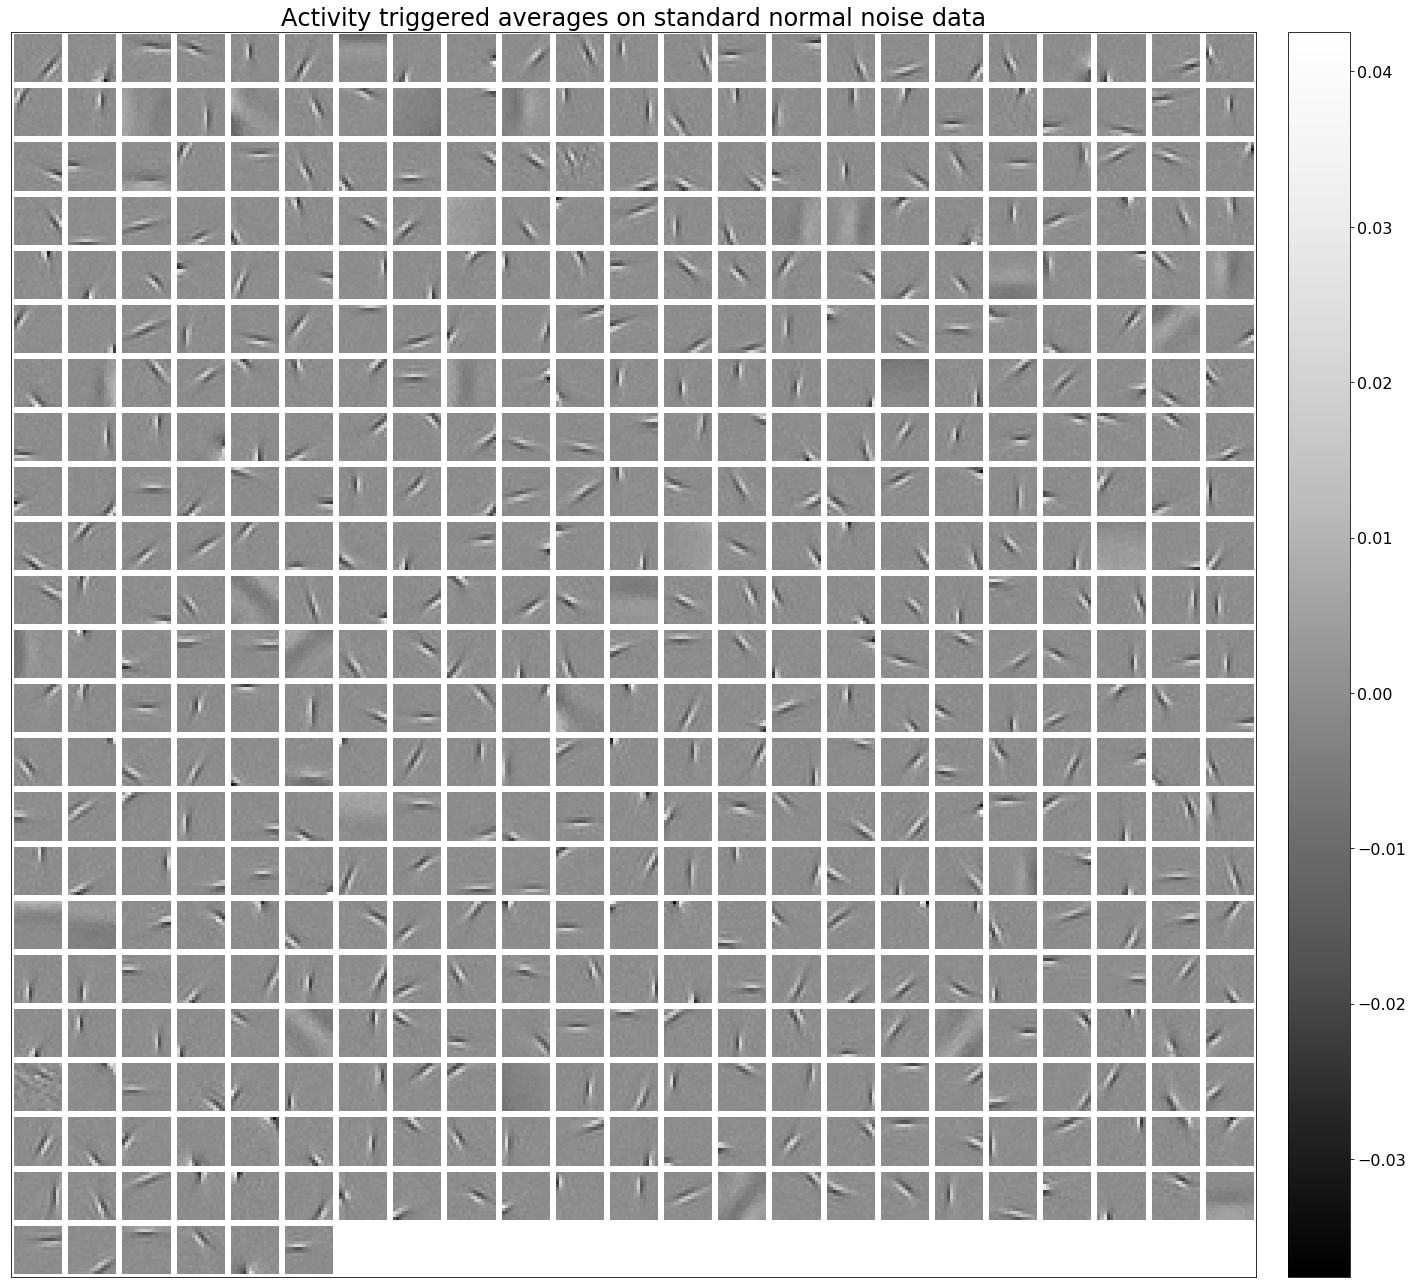

In [10]:
noise_images = np.random.standard_normal(data["train"].images.shape) 
noise_evals = analyzer.evaluate_model(noise_images)
noise_atas = analyzer.compute_atas(noise_evals["weights/phi:0"],
  noise_evals["inference/activity:0"], noise_images)
noise_atas_fig = pf.plot_data_tiled(noise_atas.T.reshape(num_neurons,
  int(np.sqrt(num_pixels)), int(np.sqrt(num_pixels))), normalize=False,
  title="Activity triggered averages on standard normal noise data")

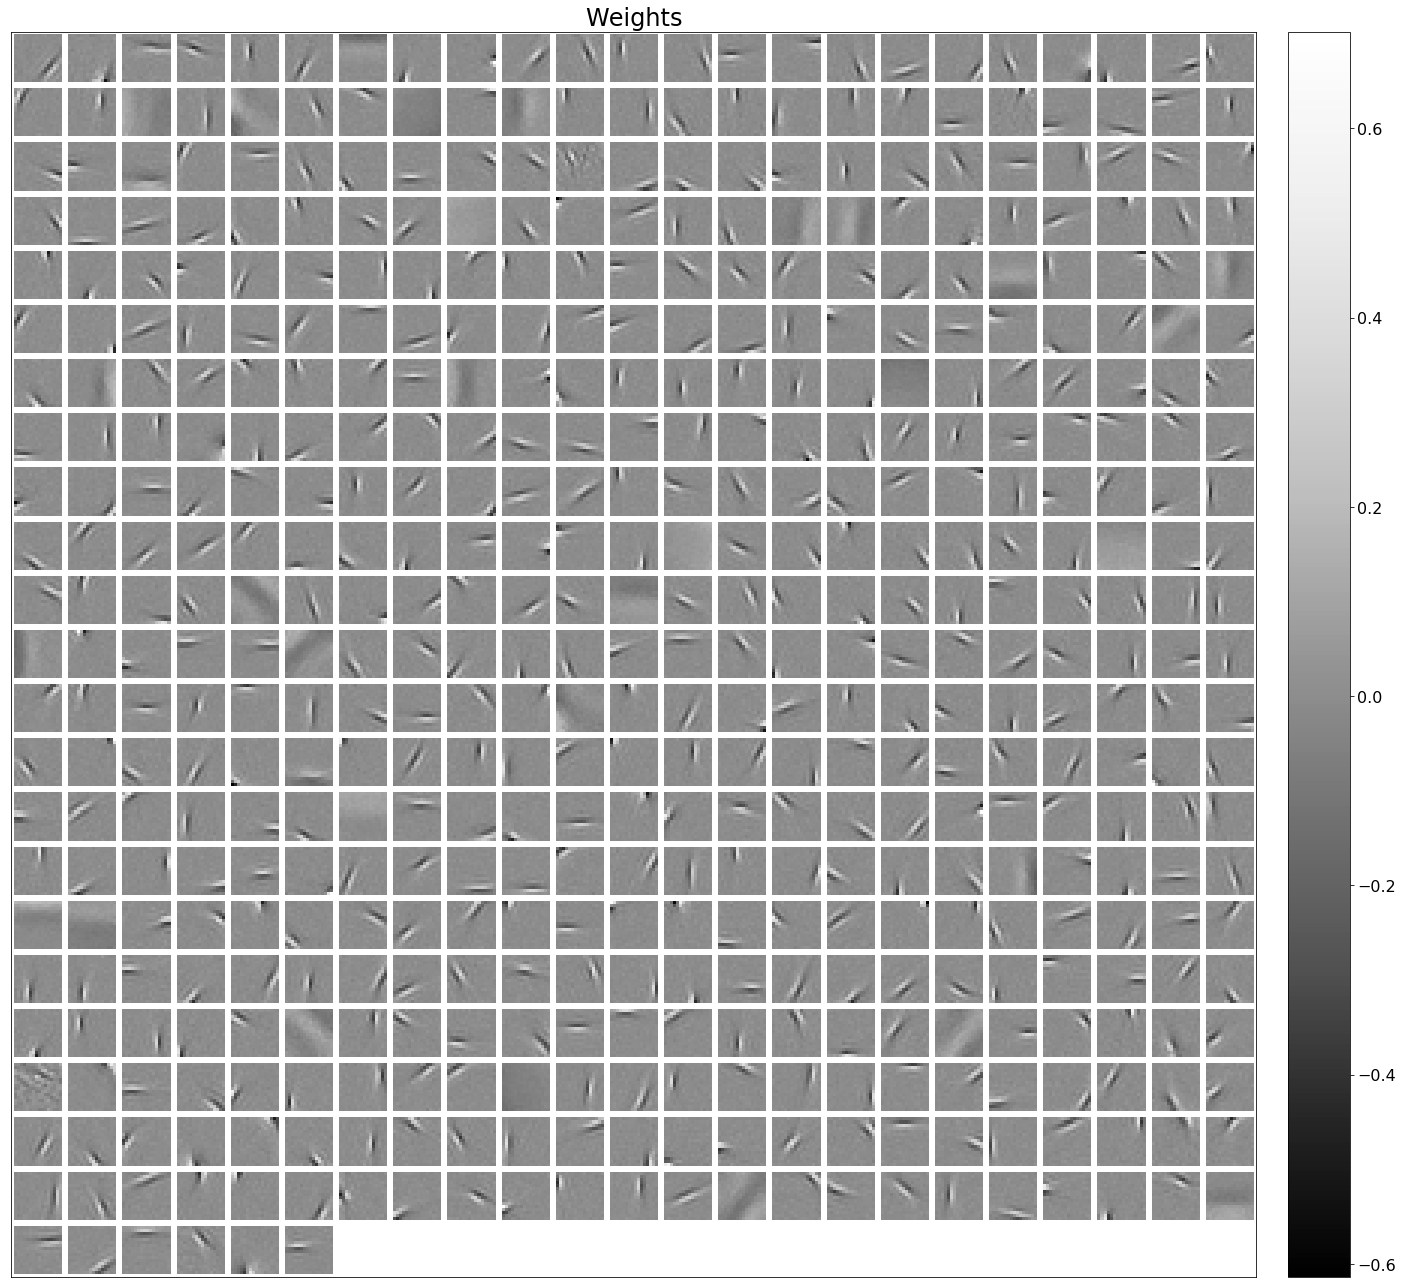

In [11]:
dict_fig = pf.plot_data_tiled(analyzer.evals["weights/phi:0"].T.reshape(analyzer.model.num_neurons,
  data["train"].num_cols, data["train"].num_rows), normalize=False, title="Weights")

In [12]:
images = data["train"].images[0:1]
inference_stats = analyzer.evaluate_inference(images)

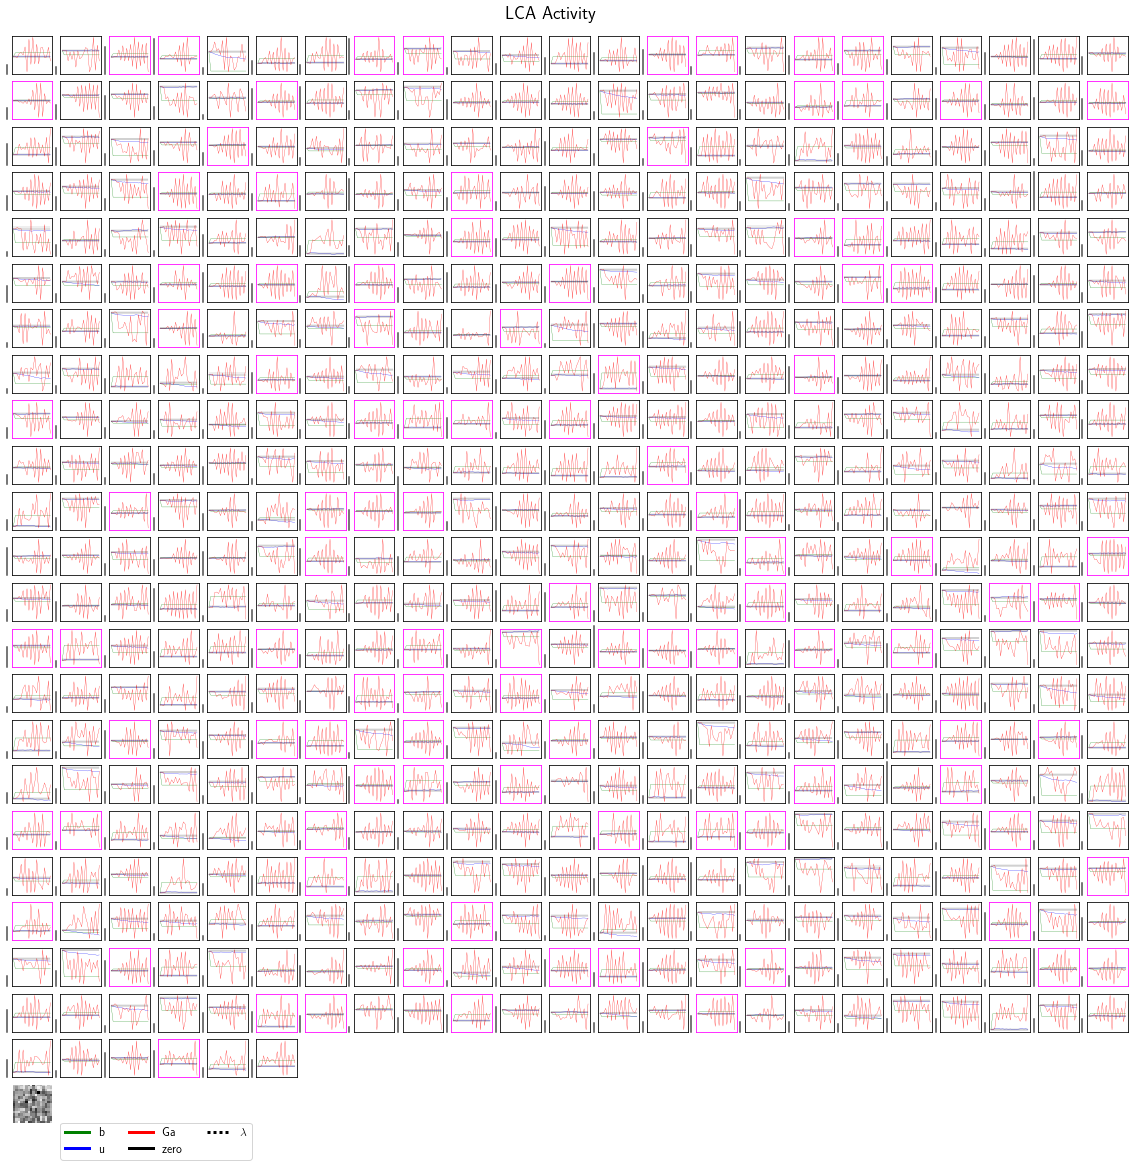

In [13]:
inference_fig = pf.plot_inference_traces(inference_stats, analyzer.model_schedule[0]["sparse_mult"], 0)

In [14]:
inference_fig.savefig("/home/dpaiton/test_inference_fig.pdf")